In [62]:
import torch
import torch.nn.functional as F
import json, copy, os
import h5py
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.cluster import KMeans
import scipy as sp
from scipy.cluster import hierarchy
from functools import reduce

In [3]:
from tqdm import tqdm

In [4]:
project_dir = "/home/acd13805eb/SGG/SGG-TD2"
image_file = json.load(open(f'{project_dir}/datasets/vg/image_data.json'))
vocab_file = json.load(open(f'{project_dir}/datasets/vg/VG-SGG-dicts-with-attri.json'))
data_file = h5py.File(f'{project_dir}/datasets/vg/VG-SGG-with-attri.h5', 'r')
# remove invalid image
corrupted_ims = [1592, 1722, 4616, 4617]
tmp = []
for item in image_file:
    if int(item['image_id']) not in corrupted_ims:
        tmp.append(item)
image_file = tmp

In [196]:
result_path = '/groups/gcc50494/home/ohashi/checkpoints/motifs-knowledgetrans-sgcls-exmp-2cluster/RELU/concat_margin40_from_record_mse_percls_avg/ktall_cls0.1'
detected_origin_path = f'{result_path}/inference/VG_stanford_filtered_with_attribute_test/'
detected_origin_result = torch.load(detected_origin_path + 'eval_results.pytorch')
detected_info = json.load(open(detected_origin_path + 'visual_info.json'))

In [6]:
def bbox_match(pred, gt):
    """Args:
        pred: [x0, y0, x1, y1]
        gt: same as above
    Returns: whether objects in gt and prediction are seen as same objects
    """
    xA = max(pred[0], gt[0])
    yA = max(pred[1], gt[1])
    xB = min(pred[2], gt[2])
    yB = min(pred[3], gt[3])
    intra_area = max(0, xB-xA+1)*max(0, yB-yA+1)
    pred_area = (pred[2]-pred[0]+1)*(pred[3]-pred[1]+1)
    gt_area = (gt[2]-gt[0]+1)*(gt[3]-gt[1]+1)
    iou = intra_area/float(pred_area+gt_area-intra_area)
    return iou>0.5

In [7]:
def find_match(pred_rels, gt_rels):
    """
    pred_rels, gt_rels: relation triplets
        sub_label: label of subject (String)
        obj_label: label of object  (String)
        sub_bbox:  bbox of subject  ([num_rel, 4])
        obj_bbox:  bbox of object   ([num_rel, 4])
        rel_label: relation label   (Int)
    """
    selected_pred_label = []
    selected_gt_label = []
    # for each gt, check pair matched prediction (if it has corresponding prediction, put 1)
    pair_found = [0 for x in range(len(gt_rels))]
    # for each prediction, check all matched gt
    pred_to_gt = [[] for x in range(len(pred_rels))]
    for i, pre in enumerate(pred_rels):
        for j, gt in enumerate(gt_rels):
            if pre["sub_label"]==gt["sub_label"] and pre["obj_label"]==gt["obj_label"] and bbox_match(pre["sub_bbox"],gt["sub_bbox"] ) and bbox_match(pre["obj_bbox"], gt["obj_bbox"]):
                selected_pred_label.append(pre["rel_label"])
                selected_gt_label.append(gt["rel_label"])
                pair_found[j] = 1
                if pre["rel_label"]==gt["rel_label"]:
                    pred_to_gt[i].append(j)
    # print(pred_to_gt)
    return pred_to_gt, selected_pred_label, selected_gt_label, pair_found

In [8]:
def extract_failure(pred_rels, gt_rels):
    """ See failed prediction samples
    Args:
        pred_rels: list[{sub_label: subject_label
                    obj_label: object label
                    sub_bbox: subject bbox
                    obj_bbox: object bbox
                    rel_label: relation label}]
        gt_rels: same as above
    """
    res = []
    for i, pred in enumerate(pred_rels):
        flag = False
        failed_gt = None
        # check every gt to see if a predicted predicte is failure or not
        for gt in gt_rels:
            if pred["sub_label"] == gt['sub_label'] and pred['obj_label'] == gt["obj_label"]:
                if bbox_match(pred['sub_bbox'], gt["sub_bbox"]) and bbox_match(pred["obj_bbox"], gt["obj_bbox"]):
                    if gt["rel_label"] == pred["rel_label"]:
                        flag = True
                        break
                    else:
                        failed_gt = gt
        if not flag and failed_gt:
            res.append({"prediction": pred, "groundtruth":failed_gt})
    return res  

In [9]:
pred2idx = vocab_file["predicate_to_idx"]

In [42]:
##### This is a code to see failed samples ######
result = {}
for i in tqdm(range(26446)):
    prediction = detected_origin_result["predictions"][i]
    groundtruths = detected_origin_result["groundtruths"][i]
    idx2label = vocab_file['idx_to_label']
    idx2pred = vocab_file['idx_to_predicate']
    # prediction boxes
    pred_boxes = prediction.bbox
    # predicted object label corresponding to bbox above
    pred_labels = prediction.get_field("pred_labels").long().tolist()
    # ground truth boxes
    gt_boxes = groundtruths.bbox
    # ground truth label corresponding to bbox above
    gt_labels = groundtruths.get_field("labels").tolist()
    # rel pair lists
    pred_rels = []
    gt_rels =[]
    # ground truth triplet
    gt_triplets = groundtruths.get_field('relation_tuple').tolist()
    for tri in gt_triplets:
        tmp = {}
        tmp["sub_label"] = idx2label[str(gt_labels[tri[0]])]
        tmp["obj_label"] = idx2label[str(gt_labels[tri[1]])]
        tmp["sub_bbox"] = gt_boxes[tri[0]].tolist()
        tmp["obj_bbox"] = gt_boxes[tri[1]].tolist()
        tmp["rel_label"] = idx2pred[str(tri[2])]
        gt_rels.append(tmp)
    # prediction relation triplet
    pred_rel_pair = prediction.get_field('rel_pair_idxs').long().tolist()
    pred_rel_label = prediction.get_field('pred_rel_labels').long()[:100]
    for j, k in zip(pred_rel_pair, pred_rel_label.tolist()):
        tmp = {}
        tmp["sub_label"] = idx2label[str(pred_labels[j[0]])]
        tmp["obj_label"] = idx2label[str(pred_labels[j[1]])]
        tmp["sub_bbox"] = pred_boxes[j[0]].tolist()
        tmp["obj_bbox"] = pred_boxes[j[1]].tolist()
        tmp["rel_label"] = idx2pred[str(k)]
        pred_rels.append(tmp)
    failure = extract_failure(pred_rels, gt_rels)
    result[str(i)] = failure

100%|██████████| 26446/26446 [00:15<00:00, 1739.09it/s]


In [28]:
with open ("/home/miskai/デスクトップ/related-work/scene-graph-benchmark/SGG-TD2/analysis/kt-less-patience--predcls-failure.json", "w") as f:
    json.dump(result, f, indent=2)

# confusion matrix

In [184]:
pred = []
gt = []
gt_nums = []
recalls = []
pair_matchs = []
idxs = []
# for i in tqdm(range(1)):
for i in tqdm(range(26446)):
    gt_num = 0
    prediction = detected_origin_result["predictions"][i]
    groundtruths = detected_origin_result["groundtruths"][i]
    idx2label = vocab_file['idx_to_label']
    idx2pred = vocab_file['idx_to_predicate']
    # prediction boxes
    pred_boxes = prediction.bbox
    # predicted object label corresponding to bbox above
    pred_labels = prediction.get_field("pred_labels").long().tolist()
    # ground truth boxes
    gt_boxes = groundtruths.bbox
    # ground truth label corresponding to bbox above
    gt_labels = groundtruths.get_field("labels").tolist()
    # rel pair lists
    pred_rels = []
    gt_rels =[]
    # ground truth triplet
    gt_triplets = groundtruths.get_field('relation_tuple').tolist()
    gt_num = len(gt_triplets)
    gt_nums.append(gt_num)
    for tri in gt_triplets:
        tmp = {}
        tmp["sub_label"] = idx2label[str(gt_labels[tri[0]])]
        tmp["obj_label"] = idx2label[str(gt_labels[tri[1]])]
        tmp["sub_bbox"] = gt_boxes[tri[0]].tolist()
        tmp["obj_bbox"] = gt_boxes[tri[1]].tolist()
        tmp["rel_label"] = tri[2]
        gt_rels.append(tmp)
    # prediction relation triplet
    pred_rel_pair = prediction.get_field('rel_pair_idxs').long().tolist()
    pred_rel_label = prediction.get_field('pred_rel_labels').long()[:100].tolist()
    for j, k in zip(pred_rel_pair, pred_rel_label):
        tmp = {}
        tmp["sub_label"] = idx2label[str(pred_labels[j[0]])]
        tmp["obj_label"] = idx2label[str(pred_labels[j[1]])]
        tmp["sub_bbox"] = pred_boxes[j[0]].tolist()
        tmp["obj_bbox"] = pred_boxes[j[1]].tolist()
        tmp["rel_label"] = k
        pred_rels.append(tmp)
    pred_to_gt, selected_pred_label, selected_gt_label, pair_found = find_match(pred_rels, gt_rels)
    match = reduce(np.union1d, pred_to_gt)
    rec = float(len(match))/float(gt_num)
    recalls.append(rec)
    pair_matchs.append(float(np.sum(pair_found))/float(gt_num))
    pred = pred+selected_pred_label
    gt = gt+selected_gt_label
    # idxs = idxs+[i for _ in range(len(selected_gt_label))]

100%|██████████| 26446/26446 [01:04<00:00, 410.29it/s]


In [178]:
len(pred) == len(gt)

True

In [185]:
# Recall@100
np.mean(recalls)

0.6359990546193012

In [186]:
# pair match accuracy
np.mean(pair_matchs)

0.9758089362601483

In [164]:
len(pred)

164414

In [33]:
pred = np.array(pred)
gt = np.array(gt)
len(pred[pred==gt])/len(gt)

0.6776065298575548

In [34]:
cnt = {}
for g in gt:
    g_pred = idx2pred[str(g)]
    if g_pred not in cnt.keys():
        cnt[g_pred] = 1
    else:
        cnt[g_pred] += 1
print(cnt)

{'on': 58863, 'has': 22265, 'near': 5969, 'under': 1286, 'hanging from': 267, 'wearing': 18367, 'in': 9336, 'above': 2029, 'of': 18790, 'sitting on': 1813, 'behind': 3469, 'with': 4770, 'carrying': 611, 'parked on': 361, 'walking on': 495, 'on back of': 128, 'in front of': 993, 'at': 543, 'riding': 1787, 'holding': 3943, 'along': 124, 'wears': 1930, 'looking at': 233, 'laying on': 280, 'watching': 157, 'over': 367, 'across': 53, 'to': 129, 'standing on': 1211, 'painted on': 62, 'growing on': 80, 'belonging to': 819, 'part of': 145, 'against': 49, 'flying in': 17, 'attached to': 819, 'between': 155, 'walking in': 79, 'for': 221, 'eating': 231, 'covered in': 162, 'and': 142, 'using': 233, 'mounted on': 163, 'covering': 217, 'from': 67, 'lying on': 142, 'says': 9, 'playing': 17, 'made of': 16}


In [104]:
val_mat = confusion_matrix(gt, pred)

In [105]:
mat = copy.deepcopy(val_mat).astype(float)
for i in range(mat.shape[0]):
    if np.sum(mat[i]):
        mat[i] = mat[i]/np.sum(mat[i])

In [106]:
labels = np.array([idx2pred[str(i)] for i in set(gt)], dtype=str)

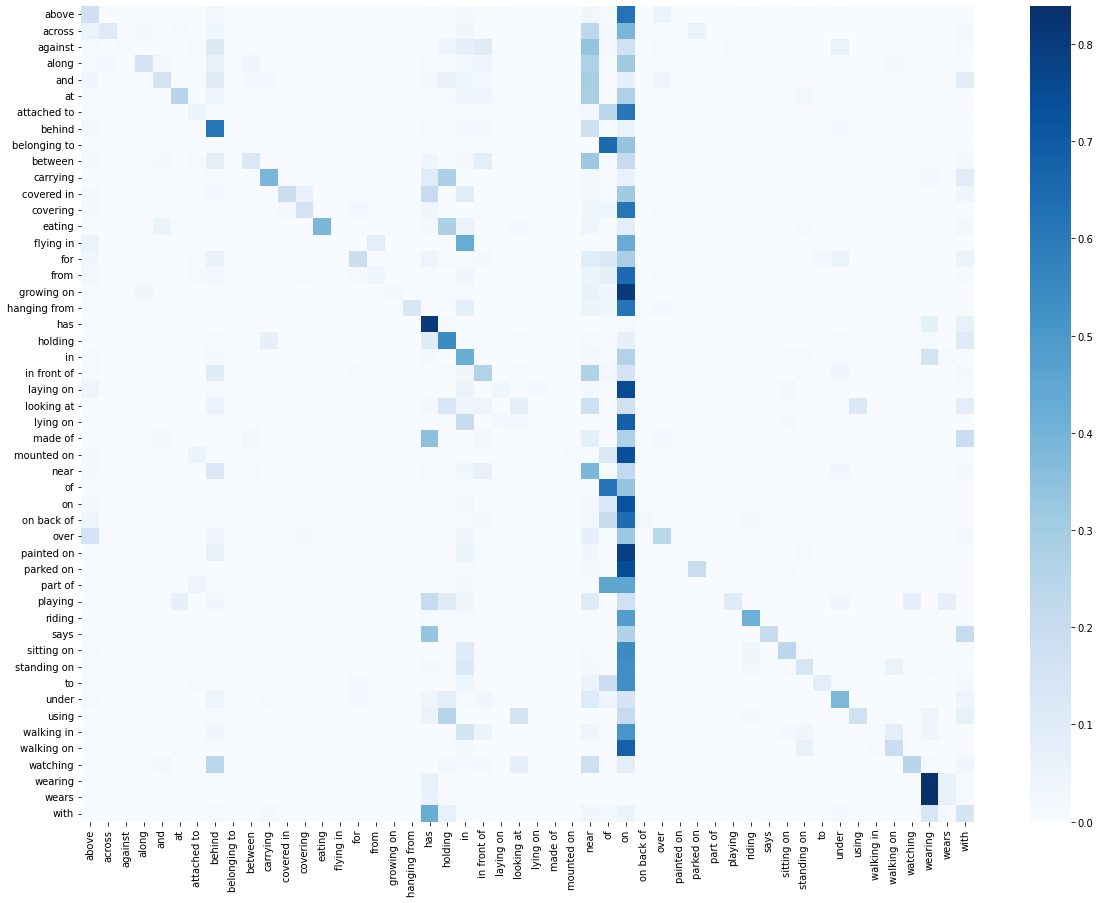

In [107]:
plt.figure(figsize=(20,15))
sns.heatmap(mat, cmap="Blues", xticklabels=labels, yticklabels=labels)
save_path = os.path.join(result_path, "conf_matrix.png")
plt.savefig(save_path, dpi=300)

# Hierarchical Analysis

In [149]:
#find matched pair
pred = []
gt = []
gt_nums = []
idxs = []
# for i in tqdm(range(1)):
for i in tqdm(range(26446)):
    gt_num = 0
    prediction = detected_origin_result["predictions"][i]
    groundtruths = detected_origin_result["groundtruths"][i]
    idx2label = vocab_file['idx_to_label']
    idx2pred = vocab_file['idx_to_predicate']
    # prediction boxes
    pred_boxes = prediction.bbox
    # predicted object label corresponding to bbox above
    pred_labels = prediction.get_field("pred_labels").long().tolist()
    # ground truth boxes
    gt_boxes = groundtruths.bbox
    # ground truth label corresponding to bbox above
    gt_labels = groundtruths.get_field("labels").tolist()
    # rel pair lists
    pred_rels = []
    gt_rels =[]
    # ground truth triplet
    gt_triplets = groundtruths.get_field('relation_tuple').tolist()
    gt_num = len(gt_triplets)
    gt_nums.append(gt_num)
    for tri in gt_triplets:
        tmp = {}
        tmp["sub_label"] = idx2label[str(gt_labels[tri[0]])]
        tmp["obj_label"] = idx2label[str(gt_labels[tri[1]])]
        tmp["sub_bbox"] = gt_boxes[tri[0]].tolist()
        tmp["obj_bbox"] = gt_boxes[tri[1]].tolist()
        tmp["rel_label"] = tri[2]
        gt_rels.append(tmp)
    # prediction relation triplet
    pred_rel_pair = prediction.get_field('rel_pair_idxs').long().tolist()
    pred_rel_label = prediction.get_field('pred_rel_labels').long()[:100].tolist()
    for j, k in zip(pred_rel_pair, pred_rel_label):
        tmp = {}
        tmp["sub_label"] = idx2label[str(pred_labels[j[0]])]
        tmp["obj_label"] = idx2label[str(pred_labels[j[1]])]
        tmp["sub_bbox"] = pred_boxes[j[0]].tolist()
        tmp["obj_bbox"] = pred_boxes[j[1]].tolist()
        tmp["rel_label"] = k
        pred_rels.append(tmp)
    pred_to_gt, selected_pred_label, selected_gt_label, pair_found = find_match(pred_rels, gt_rels)
    pred = pred+selected_pred_label
    gt = gt+selected_gt_label
    # idxs = idxs+[i for _ in range(len(selected_gt_label))]

100%|██████████| 26446/26446 [00:29<00:00, 882.19it/s] 


In [165]:
head = ["on", "has", "wearing", "of", "in", "near", "behind"]
body = ["with", "holding", "above", "under", "wears", "sitting on", "in front of", "riding", "standing on", "at", "attached to", "over", "carrying", "walking on", "for", "looking at", "watching", "hanging from", "belonging to", "and", "parked on"]
tail = ["between", "laying on", "along", "eating", "covering", "covered in", "part of", "using", "to", "on back of", "across", "mounted on", "lying on", "walking in", "against", "from", "growing on", "painted on", "made of", "playing", "says", "flying in"]
head = [pred2idx[h] for h in head]
body = [pred2idx[b] for b in body]
tail = [pred2idx[t] for t in tail]

In [166]:
top10 = ["on", "has", "wearing", "of", "in", "near", "behind", "with", "holding", "above"]
middle = ["under", "wears", "sitting on", "in front of", "riding", "standing on", "at", "attached to", "over", "carrying", "walking on", "for", "looking at", "watching", "hanging from", "belonging to", "and", "parked on", "between", "laying on", "along", "eating", "covering", "covered in", "part of"]
bottom15 = ["using", "to", "on back of", "across", "mounted on", "lying on", "walking in", "against", "from", "growing on", "painted on", "made of", "playing", "says", "flying in"]
top10 = [pred2idx[t] for t in top10]
middle = [pred2idx[m] for m in middle]
bottom15 = [pred2idx[b] for b in bottom15]

In [192]:
json_file = "/home/acd13805eb/SGG/SGG-PS/datasets/vg/predcls_clusters/motifs/2cluster.json"
taxonomy = open(json_file)
taxonomy = json.load(taxonomy)

In [193]:
pars = taxonomy["children"]["root"]
par_dic = {}
for par in pars:
    for ch in taxonomy["children"][par]:
        par_dic[pred2idx[ch]] = par

In [194]:
count = 0
correct = 0
head_count = 0
head_correct = 0
body_count = 0
body_correct = 0
tail_count = 0
tail_correct = 0
failed_predicate = []
for pre, gr in zip(pred, gt):
    if par_dic[pre]==par_dic[gr]:
        correct += 1
        if gr in head:
            head_correct += 1
        elif gr in body:
            body_correct += 1
        else:
            tail_correct += 1
    else:
        failed_predicate.append((idx2pred[str(pre)], idx2pred[str(gr)])) 
    count += 1
    if gr in head:
        head_count += 1
    elif gr in body:
        body_count += 1
    else:
        tail_count += 1
print(f"count: {count}")
print(f"head count: {head_count}")
print(f"body count: {body_count}")
print(f"tail count: {tail_count}")
print(f"Root Accuracy: {correct/count}")
print(f"Head Accuracy: {head_correct/head_count}")
print(f"Body Accuracy: {body_correct/body_count}")
print(f"Tail Accuracy: {tail_correct/tail_count}")

count: 231722
head count: 191179
body count: 36655
tail count: 3888
Root Accuracy: 0.9301404268908433
Head Accuracy: 0.9579085569021702
Body Accuracy: 0.8008730050470604
Tail Accuracy: 0.7834362139917695


In [195]:
count = 0
correct = 0
top_count = 0
top_correct = 0
mid_count = 0
mid_correct = 0
bot_count = 0
bot_correct = 0
failed_predicate = []
for pre, gr in zip(pred, gt):
    if par_dic[pre]==par_dic[gr]:
        correct += 1
        if gr in top10:
            top_correct += 1
        elif gr in middle:
            mid_correct += 1
        else:
            bot_correct += 1
    else:
        failed_predicate.append((idx2pred[str(pre)], idx2pred[str(gr)])) 
    count += 1
    if gr in top10:
        top_count += 1
    elif gr in middle:
        mid_count += 1
    else:
        bot_count += 1
print(f"count: {count}")
print(f"top10 count: {top_count}")
print(f"middle count: {mid_count}")
print(f"bottom15 count: {bot_count}")
print(f"Root Accuracy: {correct/count}")
print(f"Top10 Accuracy: {top_correct/top_count}")
print(f"Middle Accuracy: {mid_correct/mid_count}")
print(f"Bottom15 Accuracy: {bot_correct/bot_count}")

count: 231722
top10 count: 206515
middle count: 23242
bottom15 count: 1965
Root Accuracy: 0.9301404268908433
Top10 Accuracy: 0.9531946831949253
Middle Accuracy: 0.7329403665777472
Bottom15 Accuracy: 0.8396946564885496


In [67]:
# no root KT
failed_cnt = {}
for fail in failed_predicate:
    if fail[1] in failed_cnt.keys():
        failed_cnt[fail[1]] += 1
    else:
        failed_cnt[fail[1]] = 1
print(failed_cnt)

{'in': 3289, 'on': 2897, 'sitting on': 1258, 'near': 675, 'in front of': 146, 'at': 497, 'riding': 1051, 'under': 707, 'with': 424, 'of': 384, 'laying on': 238, 'behind': 190, 'watching': 105, 'standing on': 308, 'has': 223, 'across': 3, 'above': 173, 'flying in': 16, 'looking at': 79, 'between': 133, 'holding': 204, 'eating': 43, 'wearing': 43, 'covered in': 95, 'over': 29, 'and': 69, 'attached to': 28, 'against': 9, 'to': 17, 'lying on': 112, 'along': 5, 'carrying': 8, 'wears': 4, 'for': 37, 'from': 9, 'says': 3, 'walking on': 15, 'playing': 4, 'walking in': 17, 'covering': 9, 'using': 17, 'made of': 13, 'belonging to': 3, 'mounted on': 2, 'painted on': 9, 'hanging from': 15, 'part of': 1}


In [399]:
root_mat = confusion_matrix(list(map(lambda x: x[1], failed_predicate)), list(map(lambda x: x[0], failed_predicate)))
mat = copy.deepcopy(root_mat).astype(float)
for i in range(mat.shape[0]):
    if np.sum(mat[i]):
        mat[i] = mat[i]/np.sum(mat[i])

In [400]:
labels = sorted(set(list(map(lambda x: x[1], failed_predicate))+list(map(lambda x: x[0], failed_predicate))))

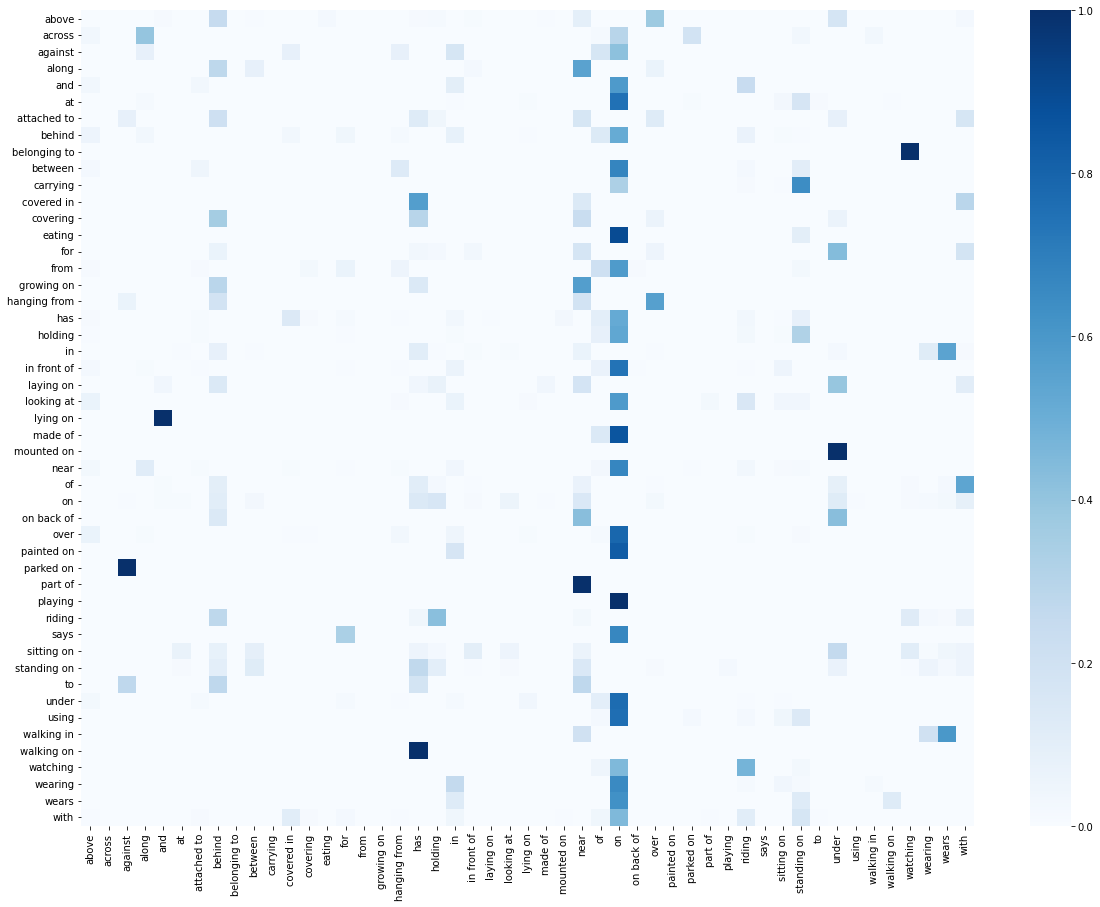

In [402]:
plt.figure(figsize=(20,15))
sns.heatmap(mat, cmap="Blues", xticklabels=labels, yticklabels=labels)
# plt.savefig("/home/miskai/デスクトップ/related-work/scene-graph-benchmark/SGG-TD2/analysis/confusion_matrix/kt2cluster-cat-base-motifs-predcls-root-conf.png", dpi=300)

# Group Analysis

In [87]:
group_path = "/home/miskai/デスクトップ/related-work/scene-graph-benchmark/SGG-TD2/datasets/vg/random_group.npy"
G = np.load(group_path, allow_pickle=True).item()
groups = G["groups"]
num_groups = G["num_groups"]
cls2group = -np.ones(51, dtype=int)
for num, group in enumerate(groups):
    for clas in group:
        cls2group[clas] = num

In [88]:
print(cls2group)

[0 7 3 0 1 1 8 5 7 1 1 6 2 6 6 3 8 0 4 8 9 7 7 5 1 0 4 2 3 9 9 9 4 8 0 0 2
 6 8 2 7 5 2 5 3 4 6 1 9 5 7]


In [98]:
def find_match_group(pred_rels, gt_rels, unconstrained=False):
    """
    pred_rels, gt_rels: relation triplets
        sub_label: label of subject (String)
        obj_label: label of object  (String)
        sub_bbox:  bbox of subject  ([num_rel, 4])
        obj_bbox:  bbox of object   ([num_rel, 4])
        rel_label: relation label   (Int) 
        (for pred_rels) candidates: predictions in every group (List)
        (for pred_rels) pred_probs: prediction probability in every group (List)
    """
    selected_pred_label = []
    selected_gt_label = []
    pred_groups = []
    gt_groups = []
    pred_probs = []
    gt_probs = []
    for pre in pred_rels:
        for gt in gt_rels:
            if pre["sub_label"]==gt["sub_label"] and pre["obj_label"]==gt["obj_label"] and bbox_match(pre["sub_bbox"],gt["sub_bbox"] ) and bbox_match(pre["obj_bbox"], gt["obj_bbox"]):
                selected_gt_label.append(gt["rel_label"])
                gt_group = cls2group[gt["rel_label"]]
                gt_groups.append(gt_group)
                gt_probs.append(pre["pred_probs"][gt_group].numpy().tolist())
                selected_pred_label.append(pre["rel_label"])
                pred_group = cls2group[pre["rel_label"]]
                pred_groups.append(pred_group)
                pred_probs.append(pre["pred_probs"][pred_group].numpy().tolist())
                if unconstrained:
                    for num, label in enumerate(pre["candidates"]):
                        if label == gt["rel_label"]:
                            selected_pred_label[-1]=label
                            pred_groups.append(num)
                            pred_probs.append(pre["pred_probs"][num].numpy().tolist())
                
    return selected_pred_label, selected_gt_label, pred_groups, gt_groups, pred_probs, gt_probs

In [101]:
pred = []
gt = []
pred_groups = []
gt_groups = []
pred_distribs = []
gt_distribs = []
for i in tqdm(range(26446)):
# for i in tqdm(range(1)):
    prediction = detected_origin_result["predictions"][i]
    groundtruths = detected_origin_result["groundtruths"][i]
    idx2label = vocab_file['idx_to_label']
    idx2pred = vocab_file['idx_to_predicate']
    # prediction boxes
    pred_boxes = prediction.bbox
    # predicted object label corresponding to bbox above
    pred_labels = prediction.get_field("pred_labels").tolist()
    # ground truth boxes
    gt_boxes = groundtruths.bbox
    # ground truth label corresponding to bbox above
    gt_labels = groundtruths.get_field("labels").tolist()
    # rel pair lists
    pred_rels = []
    gt_rels =[]
    # ground truth triplet
    gt_triplets = groundtruths.get_field('relation_tuple').tolist()
    for tri in gt_triplets:
        tmp = {}
        tmp["sub_label"] = idx2label[str(gt_labels[tri[0]])]
        tmp["obj_label"] = idx2label[str(gt_labels[tri[1]])]
        tmp["sub_bbox"] = gt_boxes[tri[0]].tolist()
        tmp["obj_bbox"] = gt_boxes[tri[1]].tolist()
        tmp["rel_label"] = tri[2]
        gt_rels.append(tmp)
    # prediction relation triplet
    pred_rel_pair = prediction.get_field('rel_pair_idxs').tolist()
    pred_rel_label = prediction.get_field('pred_rel_labels')[:50]
    for m, (j, k) in enumerate(zip(pred_rel_pair, pred_rel_label.tolist())):
        tmp = {}
        tmp["sub_label"] = idx2label[str(pred_labels[j[0]])]
        tmp["obj_label"] = idx2label[str(pred_labels[j[1]])]
        tmp["sub_bbox"] = pred_boxes[j[0]].tolist()
        tmp["obj_bbox"] = pred_boxes[j[1]].tolist()
        tmp["rel_label"] = k
        tmp["pred_probs"] = []
        tmp["candidates"] = []
        for num in range(num_groups):
            pred_probs = prediction.get_field(f"pred_rel_probs{num}")[m]
            tmp["pred_probs"].append(pred_probs)
            idx = pred_probs.argmax()
            tmp["candidates"].append(groups[num][idx])
        pred_rels.append(tmp)
    selected_pred_label, selected_gt_label, pred_g, gt_g, pred_p, gt_p = find_match_group(pred_rels, gt_rels)
    pred = pred+selected_pred_label
    gt = gt+selected_gt_label
    pred_groups = pred_groups+pred_g
    gt_groups = gt_groups+gt_g
    pred_distribs = pred_distribs+pred_p
    gt_distribs = gt_distribs+gt_p

100%|██████████| 26446/26446 [03:59<00:00, 110.37it/s]


In [102]:
len(gt)==len(pred)

True

In [104]:
len(gt_groups)==len(pred_groups)

True

In [103]:
pred = np.array(pred)
gt = np.array(gt)
len(pred[pred==gt])/len(gt)

0.017786236996685592

In [105]:
val_mat = confusion_matrix(gt_groups, pred_groups)

In [106]:
mat = copy.deepcopy(val_mat).astype(float)
for i in range(mat.shape[0]):
    if np.sum(mat[i]):
        mat[i] = mat[i]/np.sum(mat[i])

In [107]:
labels = np.array([idx2pred[str(i)] for i in set(gt)], dtype=str)

<AxesSubplot:>

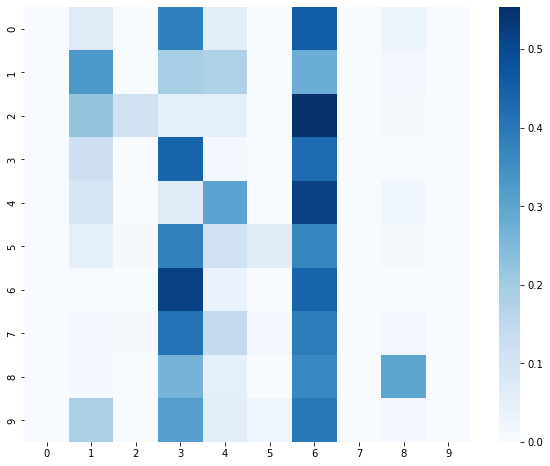

In [111]:
plt.figure(figsize=(10,8))
sns.heatmap(mat, cmap="Blues") # group confusion matrix
# plt.figure(figsize=(20,20))
# sns.heatmap(mat, cmap="Blues", xticklabels=labels, yticklabels=labels)
# plt.savefig("/home/miskai/デスクトップ/related-work/scene-graph-benchmark/SGG-TD2/analysis/random-entropy-unconstrained-conf.png", dpi=300)

In [126]:
def vis_distrib(prob, group):
    plt.bar([i+1 for i in range(len(prob))], prob, tick_label=[idx2pred[str(c)] for c in groups[group]])

In [139]:
n = 45

belonging to


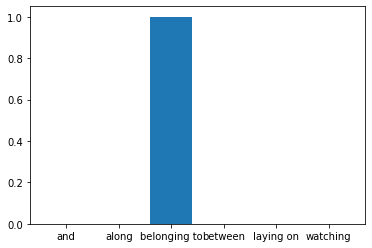

In [140]:
vis_distrib(pred_distribs[n],pred_groups[n])
print(idx2pred[str(pred[n])])

of


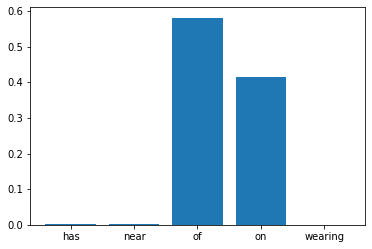

In [141]:
vis_distrib(gt_distribs[n],gt_groups[n])
print(idx2pred[str(gt[n])])